In [1]:
import sys
sys.path.append("../../src")
from pylab import plt
import numpy as np
import os
import pandas as pd
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from matplotlib.lines import Line2D
import pickle

from utils.plot_functions import set_style
os.chdir("../..")
os.getcwd()

C:\Users\jonas\AppData\Local\Temp\ipykernel_4544\3731635364.py:57: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.cax.colorbar(im, label=cbar_label)
C:\Users\jonas\AppData\Local\Temp\ipykernel_4544\3731635364.py:57: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.cax.colorbar(im, label=cbar_label)


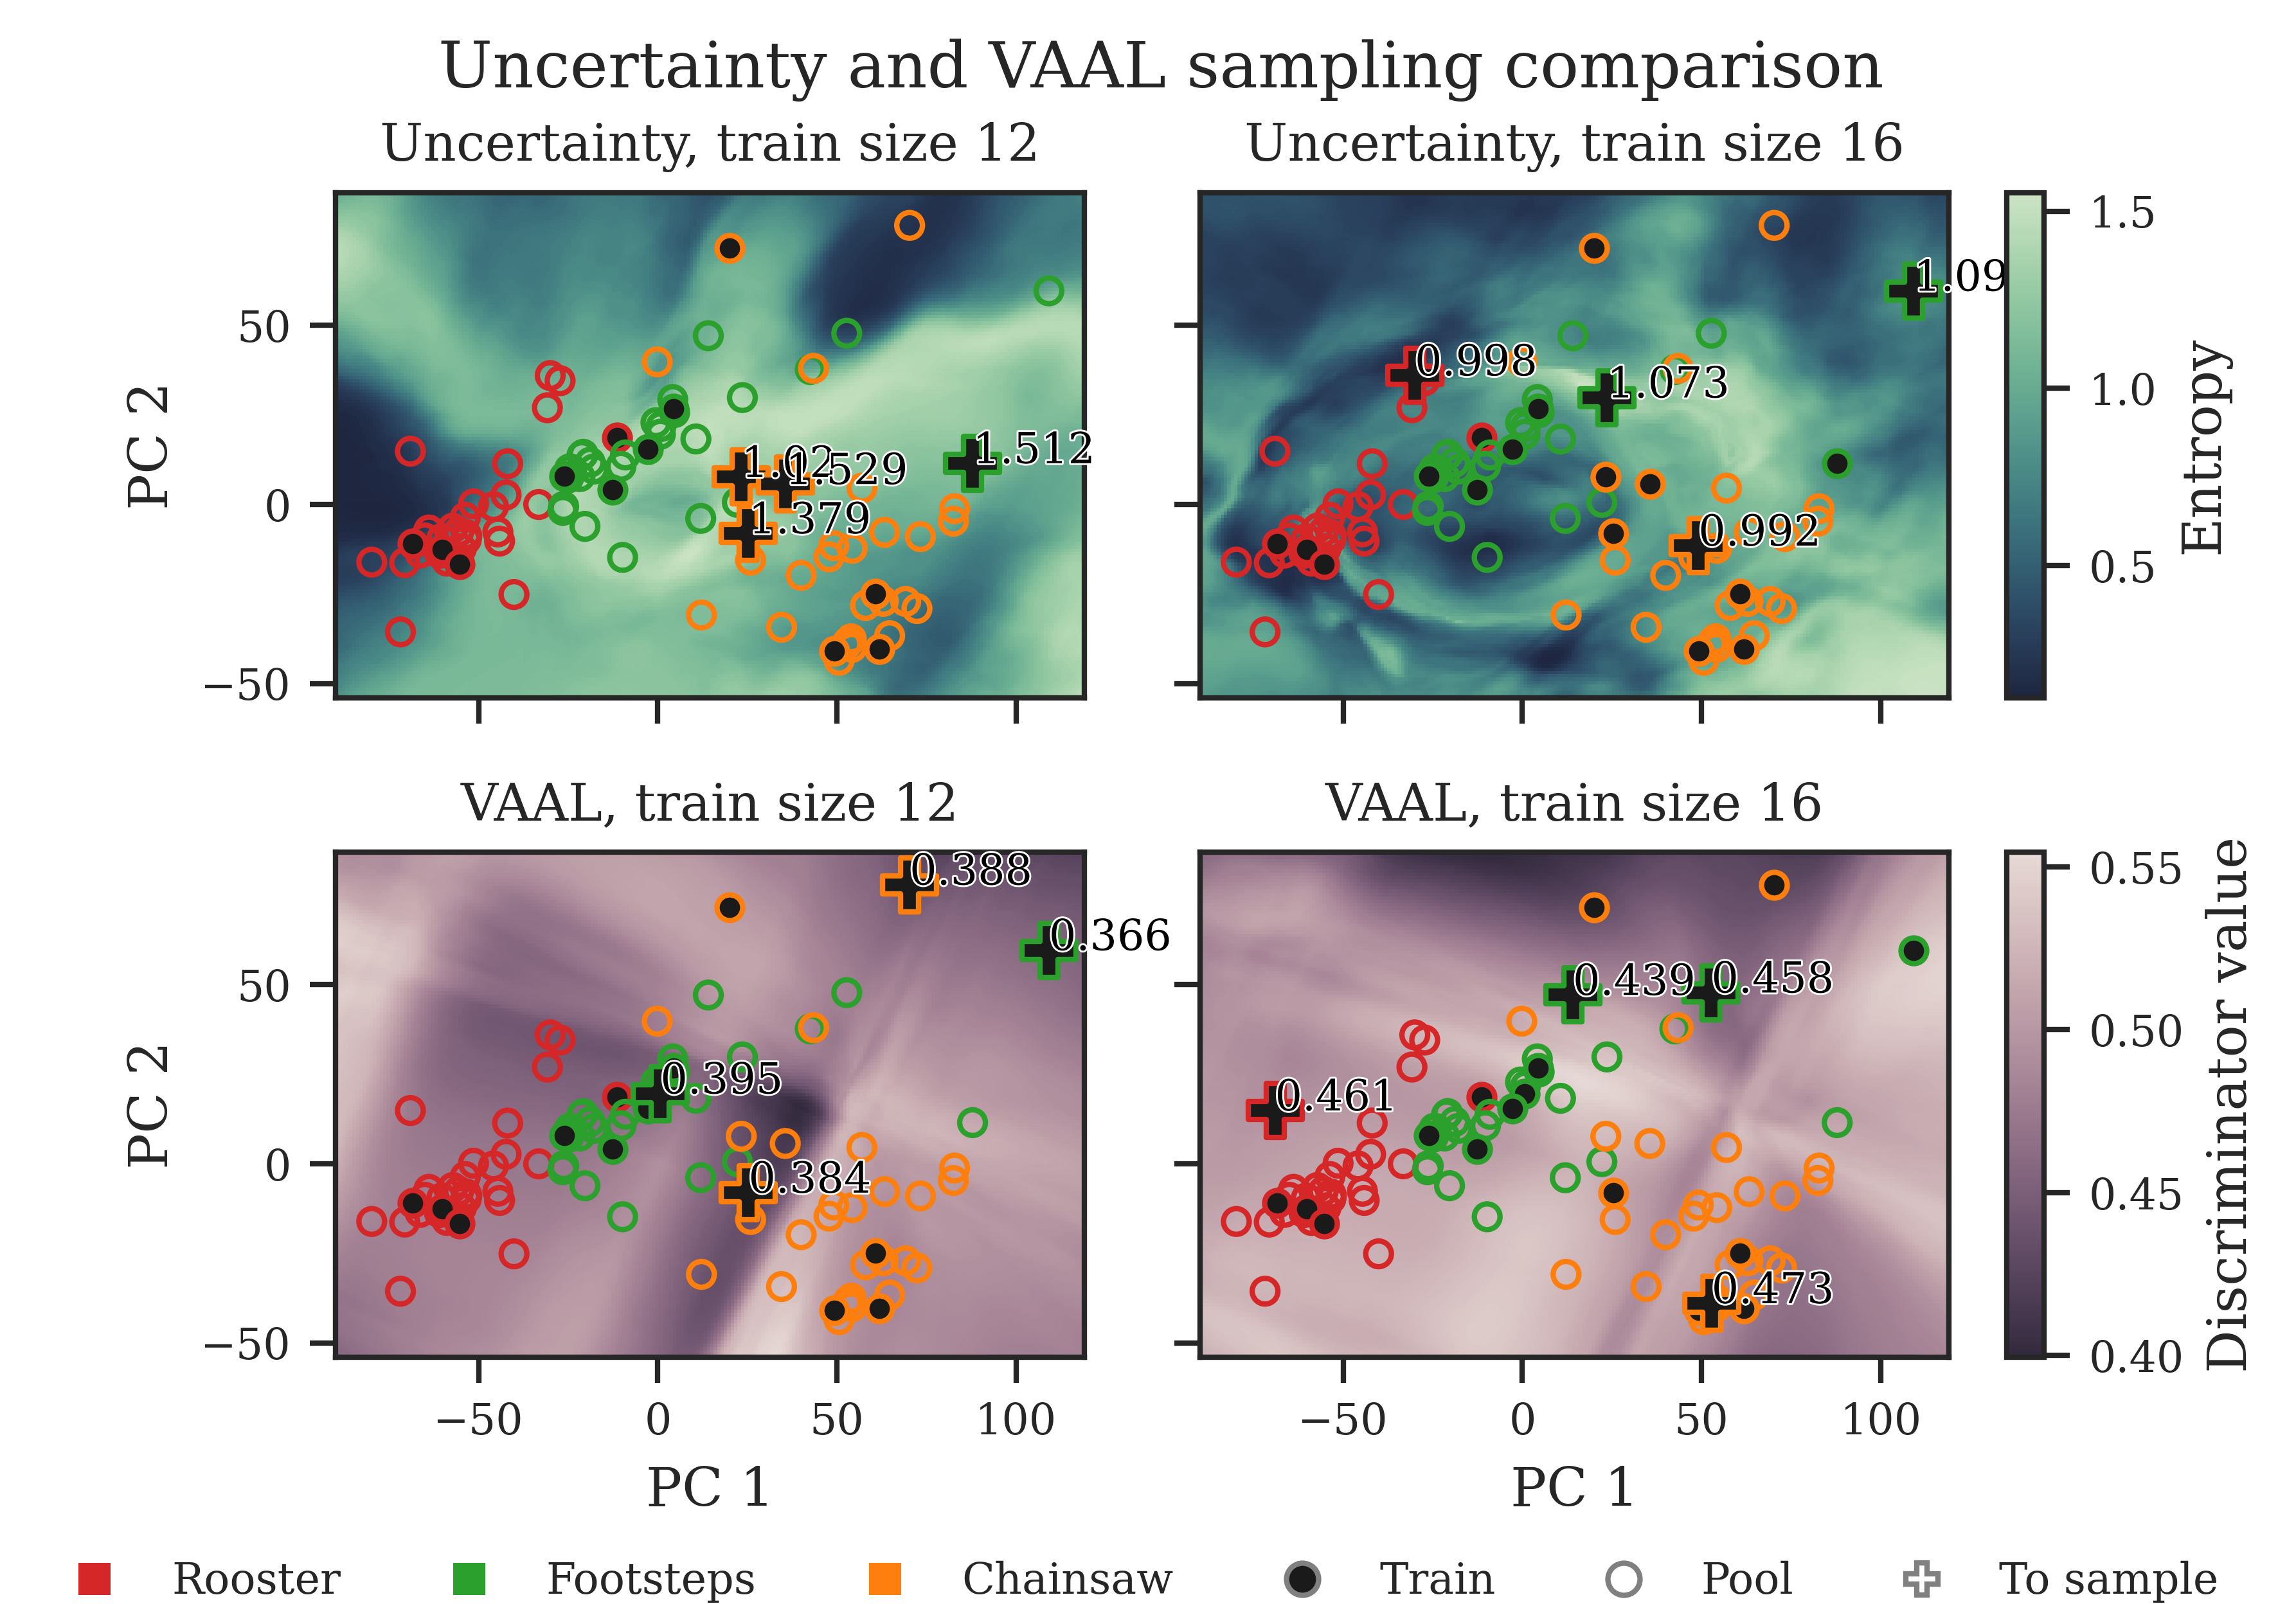

In [41]:

read_path = "docs/sampling_plots/PCA_Comparison"
save_folder = read_path
plot_folders = ["Uncertainty/plots/pc_0", "Uncertainty/plots/pc_1", "VAAL/plots/pc_0", "VAAL/plots/pc_1"]
plot_text = True
set_style()

plot_dict = {}
for exp in plot_folders:
    grid_preds = np.load(os.path.join(*[read_path, str(exp), "grid_preds.npy"]))
    grid = np.load(os.path.join(*[read_path, str(exp), "grid.npy"]))
    with open(os.path.join(os.path.join(*[read_path, str(exp), "imshow_kwargs.pkl"])), 'rb') as f:
        imshow_kwargs = pickle.load(f)
    n1, n2 = grid.shape[1:]
    plot_dict[f"Grid{exp}"] = {
            'grid_pred': grid_preds.reshape(n1, n2).T,
            'df': pd.read_csv(os.path.join(*[read_path, str(exp), "df.csv"]), index_col=0),
            'AL_method': exp.split("/")[0],
        }



plt.rcParams["font.size"] = 10
fig = plt.figure() #figsize=(set_size("project", fraction=0.7))
plt.suptitle("Uncertainty and VAAL sampling comparison")
imgrid = ImageGrid(
    fig,
    111,
    nrows_ncols=(2, 2),
    axes_pad=(0.3, 0.4),
    share_all=True,
    cbar_location="right",
    cbar_mode="edge",
    cbar_pad = 0.15,
)
for ax, name in zip(imgrid, plot_dict):
    df = plot_dict[name]['df']
    AL_method =  plot_dict[name]['AL_method']
    df_dict = dict(tuple(df.groupby("Status")))
    if AL_method == "VAAL":
        cbar_label = "Discriminator value"
        reverse = True
    else:
        cbar_label = "Entropy"
        reverse = True
    if AL_method == "VAAL":
        cmap=sns.cubehelix_palette(
                    gamma=.9, hue=0.4, as_cmap=True, reverse=reverse
                )
    else:
        cmap=sns.cubehelix_palette(
            start=0.1, rot=-0.5, as_cmap=True, reverse=reverse
        )
    im = ax.imshow(
        plot_dict[name]['grid_pred'], cmap = cmap,
        **imshow_kwargs,
    )
    ax.cax.colorbar(im, label=cbar_label)
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")
    # We make indvidual plots for more control
    custom_lines = []
    custom_labels = []
    for l in df.Labels.unique():
        colors = sns.color_palette("tab10")[1:]
        lw = 1
        sns.scatterplot(
            data=df_dict["Pool"][df_dict["Pool"].Labels == l],
            x="Principal Component 1",
            y="Principal Component 2",
            ax=ax,
            fc="none",
            edgecolor=colors[l],
            linewidth=lw,
        )
        sns.scatterplot(
            data=df_dict["Train"][df_dict["Train"].Labels == l],
            x="Principal Component 1",
            y="Principal Component 2",
            ax=ax,
            marker="o",
            color="k",
            edgecolor=colors[l],
            linewidth=lw,
        )
        sns.scatterplot(
            data=df_dict["To sample"][df_dict["To sample"].Labels == l],
            x="Principal Component 1",
            y="Principal Component 2",
            ax=ax,
            marker="P",
            color="k",
            s=100,
            edgecolor=colors[l],
            linewidth=lw,
        )

        custom_lines += [
            Line2D(
                [0],
                [0],
                linestyle="",
                color="w",
                marker="s",
                markerfacecolor=colors[l],
                markersize=6,
                markeredgecolor="none",
            )
        ]
    train_size=len(df_dict["Train"])
    ax.set_title(f"{AL_method}, train size {train_size}")
    # add legend
    custom_lines += [
        Line2D(
            [0],
            [0],
            linestyle="",
            color="gray",
            marker="o",
            markerfacecolor="k",
            markersize=6,
        ),
        Line2D(
            [0],
            [0],
            linestyle="",
            marker="o",
            color="gray",
            markerfacecolor="w",
            fillstyle="none",
            markersize=6,
        ),
        Line2D(
            [0],
            [0],
            linestyle="",
            color="gray",
            marker="P",
            markerfacecolor="w",
            markersize=6,
            markeredgewidth=1,
        ),
    ]

    custom_labels += [
        "Rooster",
        "Footsteps",
        "Chainsaw",
        "Train",
        "Pool",
        "To sample",
    ]

    if plot_text:
        for group in ["To sample"]:
            df_text = df_dict[group]
            for i in range(df_text.shape[0]):
                txt = ax.text(
                    x=df_text["Principal Component 1"].iloc[i],
                    y=df_text["Principal Component 2"].iloc[i] + 0.03,
                    s=np.round(df_text["AL_Value"].iloc[i], 3),
                    fontdict=dict(color="black", size=8),
                )
                txt.set_path_effects(
                    [PathEffects.withStroke(linewidth=0.7, foreground="w")]
                )
    ax.grid(False)

fig.legend(
    custom_lines, custom_labels, loc=(0.015, -0.01), ncol=6, framealpha=0.5, frameon=False,
)                    
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
plt.savefig(os.path.join(save_folder, f"Uncertainty_vs_VAAL.png"), bbox_inches="tight")
plt.savefig(os.path.join(save_folder, f"Uncertainty_vs_VAAL.eps"), bbox_inches="tight")
